In [1]:
### Please, notice that this code has been adapted from 
### https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 
from IPython.display import clear_output


def PeriodicBoundaryConditions(point, boundary):
    
    ##Project a point back inside a rectangular boundary with periodic boundary conditions.
    ##
    ##Args:
    ##    point (list or tuple): Coordinates of the point to be projected.
    ##    boundary (list of lists): Rectangular boundary defined as [[x_low, x_up], [y_low, y_up]].
    ##   
    ##Returns:
    ##    projected_point (list): Projected coordinates of the point.
    
    # Extract boundary limits
    x_low, x_up = boundary[0]
    y_low, y_up = boundary[1]
    
    # Extract point coordinates
    x, y = point
    
    # Apply periodic boundary conditions
    width_x = x_up - x_low
    width_y = y_up - y_low
    
    while x < x_low:
        x += width_x
    while x >= x_up:
        x -= width_x
    
    while y < y_low:
        y += width_y
    while y >= y_up:
        y -= width_y
    
    # Return the projected point
    projected_point = [x, y]
    return projected_point

def within_boundary(point,bounds):
    scales=np.diff(bounds,1).flatten()
    offsets=bounds[:,[0]].flatten()
    within = (offsets <= point) & (point <= offsets + scales.flatten())
    return within.all()

def generate_rand_points(N,bounds):
    points=np.random.rand(N,bounds.shape[0])
    scales=np.diff(bounds,1).flatten()
    offsets=bounds[:,[0]].flatten()
    return points*scales+offsets

def PSOupdate(f,V,X,pbest,pbest_obj,gbest,gbest_obj,w,c1,c2,bounds):
    "Function to do one iteration of particle swarm optimization"
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    X = np.array([PeriodicBoundaryConditions(point, bounds) for point in X.T]).T
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
    return V, X, pbest, pbest_obj, gbest, gbest_obj


def live_plot(data_dict,iteration, figsize=(8,6), title=''):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_tight_layout(True)
    
    ## plot isocurves
    img = ax.imshow(data_dict['z'], extent=data_dict['extent'], origin='lower', cmap='RdBu_r', alpha=1)
    fig.colorbar(img, ax=ax)
    ax.plot([data_dict['x_min']], [data_dict['y_min']], marker='x', markersize=5, color="white")
    contours = ax.contour(data_dict['x'], data_dict['y'], data_dict['z'], 10, colors='black', alpha=1)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    
    ## plot
    ## - personal bests (black dot)
    ## - positions (blue)
    ## - velocities (blue arrows)
    ## - global best (black star)
    
    pbest_plot = ax.scatter(data_dict['pbest'][0], data_dict['pbest'][1], marker='o', color='black', alpha=0.5)
    p_plot = ax.scatter(data_dict['X'][0], data_dict['X'][1], marker='o', color='blue', alpha=0.5)
    p_arrow = ax.quiver(data_dict['X'][0], data_dict['X'][1], data_dict['V'][0], data_dict['V'][1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
    gbest_plot = plt.scatter([data_dict['gbest'][0]], [data_dict['gbest'][1]], marker='*', s=100, color='red', alpha=0.8)
    ax.set_xlim(data_dict['xlim'])
    ax.set_ylim(data_dict['ylim'])
    
    title = 'Iteration {:02d}'.format(iteration)
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(data_dict['pbest'].T)
    p_plot.set_offsets(data_dict['X'].T)
    p_arrow.set_offsets(data_dict['X'].T)
    p_arrow.set_UVC(data_dict['V'][0], data_dict['V'][1])
    gbest_plot.set_offsets(data_dict['gbest'].reshape(1,-1))                                                
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()
                                                     
    return 

In [2]:
def f(x,y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

# Contour plot: With the global minimum showed as "X" on the plot
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]


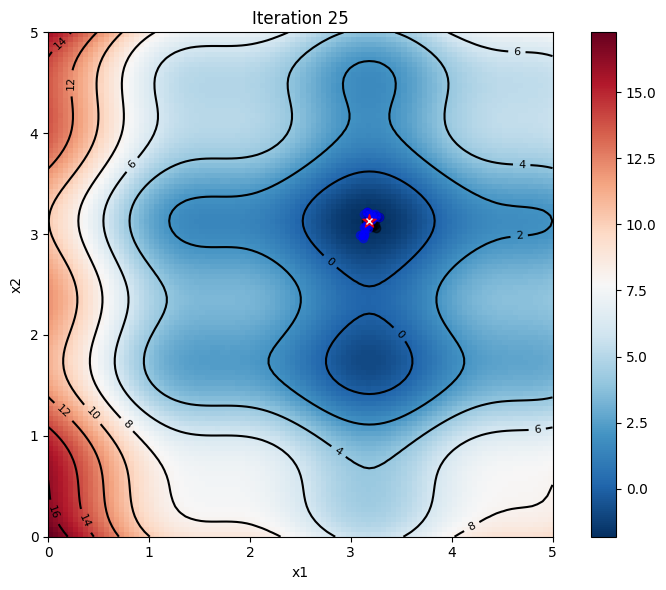

In [3]:
# Hyper-parameter of the algorithm
c1 = 0.1
c2 = 0.1
w = 0.8
N = 25

# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()




PSO_dict={'x':x,
           'y':y,
           'z':z,
           'x_min':x_min,
           'y_min':y_min,
           'X':X,
           'V':V,
           'pbest':pbest,
           'gbest': gbest,
           'pbest_obj':pbest_obj,
           'gbest_obj':gbest_obj,
           'w':w, 
           'c1':c1,
           'c2':c2,
           'extent':[0, 5, 0, 5],
           'xlim':[0,5],
           'ylim':[0,5]
           }




for iteration in range(0,N+1):
    if iteration>0:
        PSO_dict['V'], PSO_dict['X'], \
        PSO_dict['pbest'], PSO_dict['pbest_obj'], \
        PSO_dict['gbest'], PSO_dict['gbest_obj'] = PSOupdate(f,
                                                             PSO_dict['V'],
                                                             PSO_dict['X'],
                                                             PSO_dict['pbest'],
                                                             PSO_dict['pbest_obj'],
                                                             PSO_dict['gbest'],
                                                             PSO_dict['gbest_obj'],
                                                             PSO_dict['w'],
                                                             PSO_dict['c1'],
                                                             PSO_dict['c2'],
                                                             bounds=[PSO_dict['xlim'],PSO_dict['ylim']])
    live_plot(PSO_dict,
              iteration, 
              figsize=(8,6), 
              title='prova')
    

## Understand role of hyperparameters

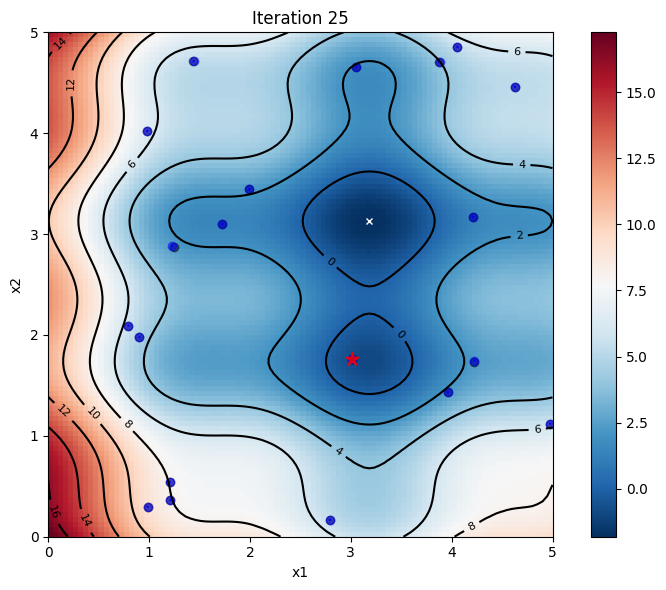

In [8]:

# Hyper-parameters of the algorithm
c1 = 1
c2 = 0
w = 0.8
N = 25


# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()




PSO_dict={'x':x,
           'y':y,
           'z':z,
           'x_min':x_min,
           'y_min':y_min,
           'X':X,
           'V':V,
           'pbest':pbest,
           'gbest': gbest,
           'pbest_obj':pbest_obj,
           'gbest_obj':gbest_obj,
           'w':w, 
           'c1':c1,
           'c2':c2,
           'extent':[0, 5, 0, 5],
           'xlim':[0,5],
           'ylim':[0,5]
           }




for iteration in range(0,N+1):
    if iteration>0:
        PSO_dict['V'], PSO_dict['X'], \
        PSO_dict['pbest'], PSO_dict['pbest_obj'], \
        PSO_dict['gbest'], PSO_dict['gbest_obj'] = PSOupdate(f,
                                                             PSO_dict['V'],
                                                             PSO_dict['X'],
                                                             PSO_dict['pbest'],
                                                             PSO_dict['pbest_obj'],
                                                             PSO_dict['gbest'],
                                                             PSO_dict['gbest_obj'],
                                                             PSO_dict['w'],
                                                             PSO_dict['c1'],
                                                             PSO_dict['c2'],
                                                             bounds=[PSO_dict['xlim'],PSO_dict['ylim']])
    live_plot(PSO_dict,
              iteration, 
              figsize=(8,6), 
              title='prova')
    

## MOPSO

In [5]:
def dominates(f1,f2):
    f1=np.array(f1)
    f2=np.array(f2)
    return np.all(f1<=f2) and np.any(f1<f2)

def generate_rand_points(N,bounds):
    points=np.random.rand(N,bounds.shape[0])
    scales=np.diff(bounds,1).T
    offsets=bounds[:,[0]].T
    return points*scales+offsets

def generate_randn_points(N,nobj,sigma):
    points=np.random.randn(N,nobj)
    return points*sigma

def flatten(xss):
    return [x for xs in xss for x in xs]

## get Pareto optimal indices
def ParetoFront(list_fs):
    list_fs=np.array(list_fs)
    pareto_front = list()
    point_is_dominated_by={}

    for idi, _ in enumerate(list_fs):
        point_is_dominated_by[idi] = list()
    
    for id1, obj1 in enumerate(list_fs): ## upper triangular matrix
        for index2, obj2 in enumerate(list_fs[id1 + 1:]):  # Avoid redundant comparisons
            id2 = index2 + id1 + 1
            if dominates(obj1,obj2):
                point_is_dominated_by[id2].append(id1)
            elif dominates(obj2,obj1):
                point_is_dominated_by[id1].append(id2)

        if not point_is_dominated_by[id1]:
            pareto_front.append(id1)
            
    return pareto_front 


## get Pareto optimal points
def FirstParetoFront(pbest_obj):
    indices=ParetoFront(pbest_obj)
    return indices, (np.array(pbest_obj)[indices]).tolist()


## select single one among optimal solutions (in can be personal best or global best)
def select_best(pareto_optimal,indices,N=1, ref_point=[100,100]): 
    ''' 
    we select the best N solution based on the hypervolume of the solutions 
    from a reference point
    We use the roulette approach for best selection
    '''
    
    #reference point
    ref_point=np.array(ref_point)
    #compute hypervolumes
    diff=ref_point-np.array(pareto_optimal)
    hvols=diff.prod(1)
    #normalize hypervolumes
    norm_hvols=hvols/np.sum(hvols)

    # if I want to select an unique best candidate or if I need more of them
    if N==1:
        selected_best=np.random.choice(np.arange(len(pareto_optimal)), p=norm_hvols)   
    else:
        selected_best=np.random.choice(np.arange(len(pareto_optimal)), size=N, p=norm_hvols)
    
    # return selected indices and objective values
    indices=(np.array(indices)[selected_best]).tolist()
    selected=(np.array(pareto_optimal)[selected_best]).tolist()
    return indices,selected


def select_personal_and_global_best(pbest_archive,pbest_obj_archive,N=1):
    ##first select one from the best per particle
    best_personal_obj=[]
    best_personal_X=[]
    for particle in list(pbest_obj_archive.keys()):
        # list all personal best objectives
        obj_list=pbest_obj_archive[particle]
        # list all personal best positions
        x_list=pbest_archive[particle]
        # Select a single personal best point (N=1 by default)
        selected_index, selected_score = select_best(obj_list, np.arange(len(obj_list)))
        
        #append to personal best archives
        best_personal_X.append(x_list[selected_index])
        best_personal_obj.append(selected_score)
    
    ##then select the overall best N times (a global best per particle, it may not be the same)
    best_global_index, best_global_score = select_best(best_personal_obj, np.arange(len(best_personal_obj)), N)
    best_global_X = [best_personal_X[b] for b in best_global_index]
    return best_personal_X, best_personal_obj, best_global_X, best_global_score

# update archive with 1 Pareto front of collected points
def update_best(X_list,obj_list):
    PF_indices, PF_obj_list = FirstParetoFront(obj_list)
    PF_X_list = [X_list[i] for i in PF_indices]
    return PF_X_list, PF_obj_list

In [6]:


def F1(x):
    return x[0]

def wrap_F2(a,b):
    def F2(x):
        return 1 - x[0] - a * np.sin(b * np.pi * x[0]) + x[1]**2 
    return F2

###################
## DEFINE OBJECTIVE in non-convex case
###################
# parameters
a=0.1
b=3

# objectives
F2=wrap_F2(a,b)
objective_list=[F1,F2]

# define range for input
bounds = np.array([[0, 2],[-1, 1]])
###################

###################
## DEFINE MODEL HYPERPARAMETERS
###################
# Flock dimension
n_particles = 20
iterations=100

# initial velocity dispersion
sigma=0.3

# hyperparameters
c1 = c2 = 0.1
w = 0.8




# inital positions and velocities
X = generate_rand_points(n_particles,bounds)
V = generate_randn_points(n_particles,len(objective_list),sigma)

# initialize personal best positions
pbest = X.tolist()
pbest_archive=dict([(el,[val]) for el,val in zip(np.arange(n_particles),pbest)])

# initialize personal best objectives
pbest_obj = [[obj(xi) for obj in objective_list] for xi in X]
pbest_obj_archive=dict([(el,[val]) for el,val in zip(np.arange(n_particles),pbest_obj)])


for iteration in range(iterations):
    
    
    pbest, pbest_obj, gbest , gbest_obj = select_personal_and_global_best(pbest_archive,
                                                                          pbest_obj_archive,
                                                                          n_particles)


    r1, r2 = np.random.rand(2)
    V = w * V + c1 * r1 * (np.array(pbest) - X) + c2*r2*(np.array(gbest)-X)
    X = X + V

    
    current_obj=[[obj(xi) for obj in objective_list] for xi in X.tolist()]

    for key in pbest_archive.keys():
        pbest_archive[key], pbest_obj_archive[key] = update_best(pbest_archive[key]+[X.tolist()[key]],
                                                                 pbest_obj_archive[key]+[current_obj[key]])








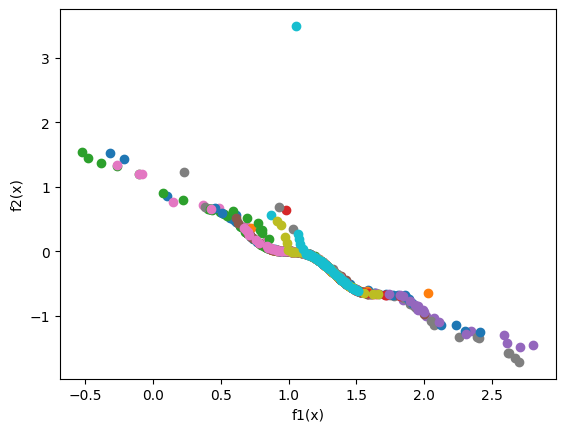

In [19]:

for key in  pbest_obj_archive.keys():
    plt.scatter(np.array(pbest_obj_archive[key])[:,0],np.array(pbest_obj_archive[key])[:,1])
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()
    